In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
sc.settings.verbosity = 3  
sc.set_figure_params()
import scFates as scf
scf.set_figure_pubready()


In [2]:
adata=sc.read("adata_all.h5ad")

In [3]:
adata_ss2=sc.read("../../SS2/data/adata_assigned.h5ad")
adata_raw_ss2=sc.read("../../SS2/data/adata_glia_raw.h5ad")
adata_raw_ss2=adata_raw_ss2[adata_ss2.obs_names]

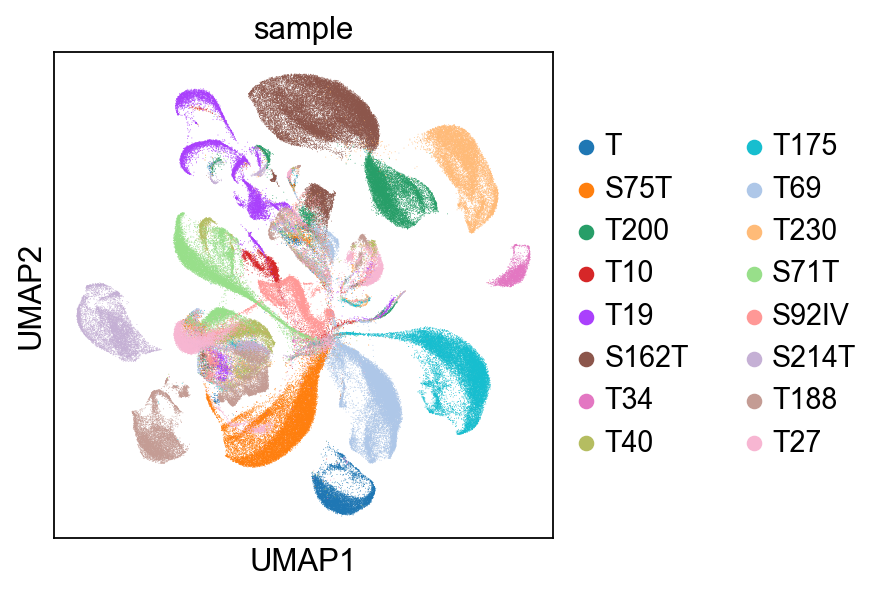

In [4]:
sc.pl.umap(adata,color="sample")

In [5]:
import pandas as pd
annot=pd.read_csv("GSE137804_Tumor_dataset_annotation.csv.gz")

In [6]:
annot=annot.loc[~annot["sample"].isin(["T214",'T174','T44','T188','T69',"T230","T200","T162"])]

In [7]:
annot["sample"].unique()

array(['T10', 'T19', 'T27', 'T34', 'T40', 'T71', 'T75', 'T92'],
      dtype=object)

In [8]:
anndict=dict(zip(["T10","T19","T27","T34","T40","S71T","S75T","S92IV"],annot["sample"].unique()))

In [9]:
annot["sample"].unique()

array(['T10', 'T19', 'T27', 'T34', 'T40', 'T71', 'T75', 'T92'],
      dtype=object)

In [10]:
anndict

{'T10': 'T10',
 'T19': 'T19',
 'T27': 'T27',
 'T34': 'T34',
 'T40': 'T40',
 'S71T': 'T71',
 'S75T': 'T75',
 'S92IV': 'T92'}

In [11]:
adata.obs["sample"]=adata.obs["sample"].cat.rename_categories(anndict)

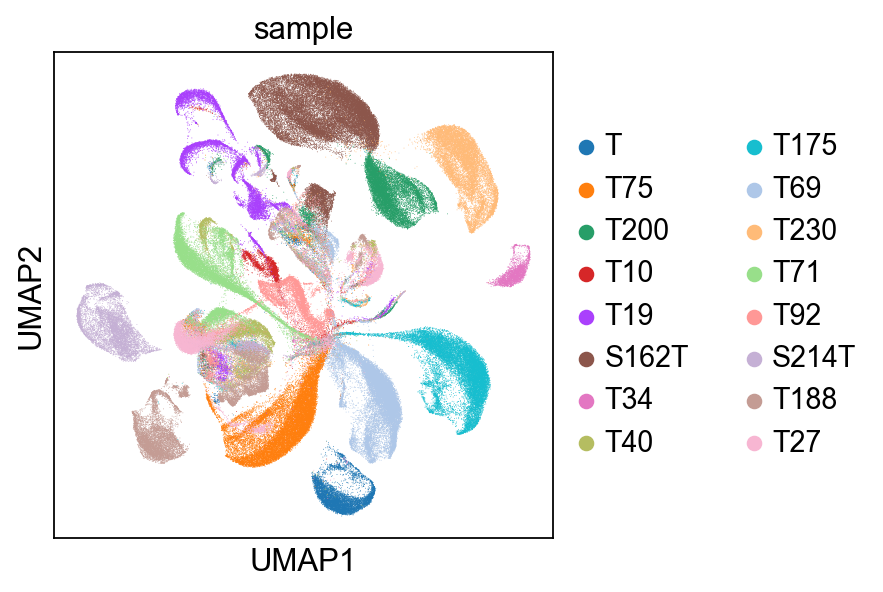

In [12]:
sc.pl.umap(adata,color="sample")

In [13]:
adata.obs["sel"]=adata.obs["sample"].isin(annot["sample"].unique()).astype(str)

In [14]:
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="<|-",facecolor="k",
                         connectionstyle = "angle,angleA=0,angleB=90"),
          zorder=0, va="center",
          xycoords="axes fraction",
          annotation_clip=False)

... storing 'sel' as categorical


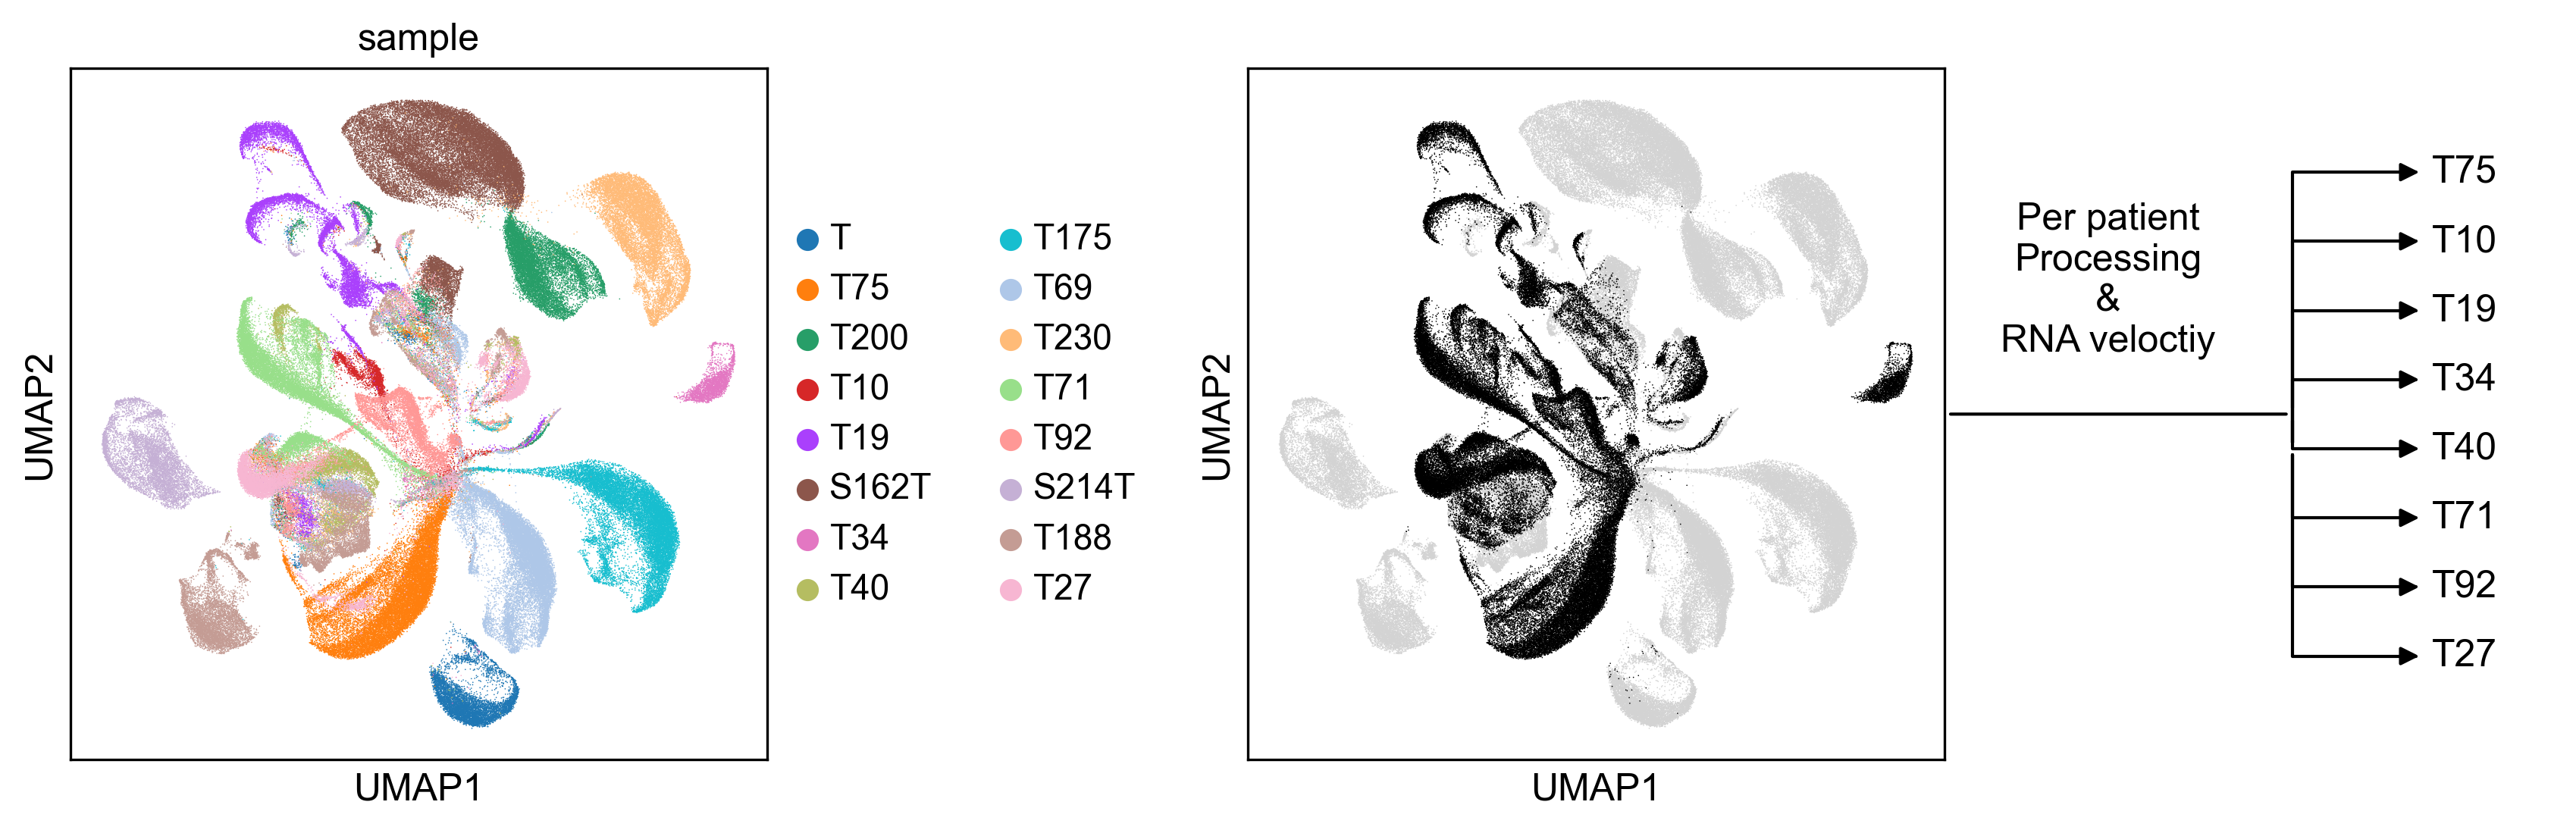

In [15]:
sc.set_figure_params(dpi=150,fontsize=12)
from matplotlib.patches import ConnectionPatch
import scvelo as scv
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,4,figsize=(14,4),gridspec_kw=dict(width_ratios=[1,.38,1,.72]))

sc.pl.umap(adata,color="sample",show=False,ax=axs[0],)
sc.pl.umap(adata,color="sel",title="",groups=["True"],palette=["k"],legend_loc="none",show=False,ax=axs[2])

fig.text(.82,.6,"Per patient\nProcessing\n&\nRNA veloctiy",ha="center",size=12)
axs[1].axis("off")
axs[3].axis("off")


axs[2].annotate("", xy=(1, .5), xytext=(1.5,.5),arrowprops=dict(arrowstyle="-",facecolor="k"), 
                zorder=0, va="center",xycoords="axes fraction",annotation_clip=False)
axs[2].annotate("T75", xy=(1.5, .5), xytext=(1.7,.85), **kw)
axs[2].annotate("T10", xy=(1.5, .45), xytext=(1.7,.75), **kw)
axs[2].annotate("T19", xy=(1.5, .45), xytext=(1.7,.65), **kw)
axs[2].annotate("T34", xy=(1.5, .45), xytext=(1.7,.55), **kw)
axs[2].annotate("T40", xy=(1.5, .5), xytext=(1.7,.45), **kw)
axs[2].annotate("T71", xy=(1.5, .45), xytext=(1.7,.35), **kw)
axs[2].annotate("T92", xy=(1.5, .45), xytext=(1.7,.25), **kw)
axs[2].annotate("T27", xy=(1.5, .45), xytext=(1.7,.15), **kw)

plt.savefig("figures/suppfig.pdf",dpi=300)


In [15]:
adata=adata[~adata.obs["sample"].isin(annot["sample"].unique())]

In [38]:
adata.obs["sample"]=adata.obs["sample"].cat.rename_categories([anndict[s] for s in adata.obs["sample"].cat.categories])

Trying to set attribute `.obs` of view, copying.


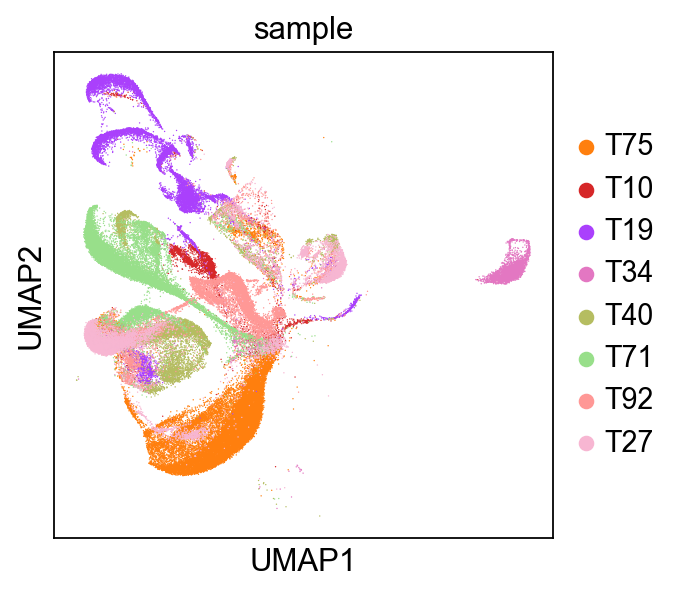

In [39]:
sc.pl.umap(adata,color="sample",cmap="tab10")

In [40]:
sc.pp.filter_genes(adata,min_cells=3)

filtered out 2631 genes that are detected in less than 3 cells


In [41]:
import cupy as cp
import rapids_scanpy_funcs as rap
scaled = cp.array(adata[:,adata.var["highly_variable"]].X.todense(), order="F")
scaled = rap.scale(scaled, max_value=10)

In [42]:
from cuml import PCA
adata.obsm["X_pca"] = (PCA(n_components=50).fit_transform(scaled)).get()

In [43]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30,method="rapids")

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [44]:
sc.tl.umap(adata,method="rapids")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


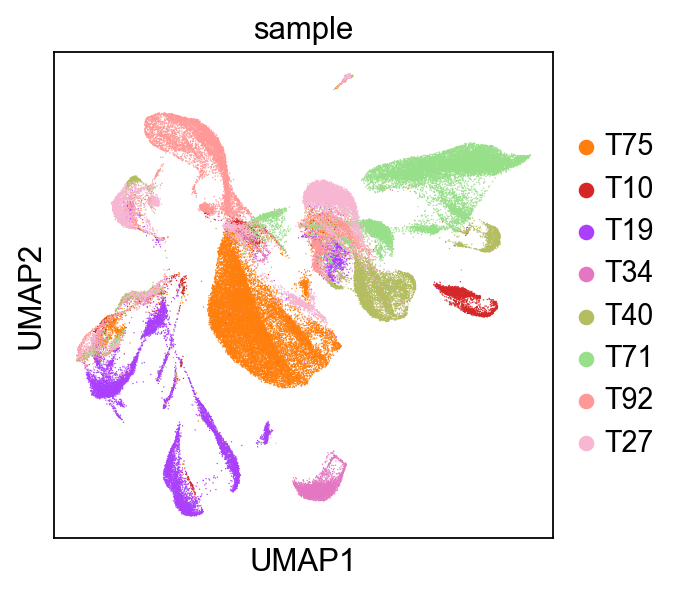

In [45]:
sc.set_figure_params(dpi_save=600)
import matplotlib.pyplot as plt
import scFates as scf
scf.set_figure_pubready()
sc.pl.umap(adata,color="sample",cmap="tab10")

In [46]:
adata.obs["bc"]=list(map(lambda x: x.split("-")[0],adata.obs_names))

adata.obs["bc"]= adata.obs[['bc', 'sample']].apply(lambda x: '-'.join(x), axis=1)

import re
annot["bc"]=list(map(lambda c: re.sub('[^ATGC]', '', c),annot.cell_id))

annot["bc"]= annot[['bc', 'sample']].apply(lambda x: '-'.join(x), axis=1)
adata_raw=sc.read("adata_raw.h5ad")
adata_raw=adata_raw[adata.obs_names]


In [47]:
adata.obs_names = adata.obs.bc.values
adata_raw.obs_names = adata.obs.bc.values

In [48]:
annot=annot[annot.annotation.isin(['tumor', 'fibroblast', 'schwann_cell'])]

In [49]:
annot=annot.drop_duplicates("bc",keep=False)

In [50]:
adata_ss2 = sc.read('../../SS2/data/adata_assigned.h5ad')

In [51]:
pd.Series(adata_raw.var_names).to_csv("to_align/features.tsv",index=False,header=False)

In [52]:
import scipy.io
for s in annot["sample"].unique():
    bcs=annot[annot["sample"]==s].bc
    scipy.io.mmwrite("to_align/"+s+"_matrix.mtx",adata_raw[annot[annot["sample"]==s].bc].X.astype(int))
    pd.Series(bcs).to_csv("to_align/"+s+"_barcodes.tsv",index=False,header=False)
    

In [53]:
samples = annot["sample"].unique()

In [54]:
import pandas as pd
ass_cols=pd.Series(adata_ss2.uns["assignments_colors"],index=adata_ss2.obs.assignments.cat.categories)

adata_ss2.obs.assignments=adata_ss2.obs.assignments.astype(str)
adata_ss2.obs.loc[adata_ss2.obs.Hub_leiden=="True","assignments"]="Hub"
adata_ss2.obs.assignments=adata_ss2.obs.assignments.astype("category")

ass_cols["Hub"]="lightgrey"

ass_cols["none"]="grey"

adata_raw_ss2.obs["assignments"]=adata_ss2.obs.assignments

Trying to set attribute `.obs` of view, copying.


In [55]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [56]:
%%R -i adata_raw_ss2
library(Seurat)
adata_glia <- as.Seurat(adata_raw_ss2,counts="X",data = "X")
p2_glia=pagoda2::basicP2proc(adata_glia@assays$RNA@counts,n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)

creating space of type angular done
adding data ... done
building index ... done
querying ... done


In [58]:
%%R -i samples
library(conos)
library(Matrix)

assignments=adata_glia@meta.data$assignments
names(assignments)=colnames(adata_glia)
features = readLines("to_align/features.tsv")
for (s in samples){
    mtx=as(readMM(paste0("to_align/",s,"_matrix.mtx")), "dgCMatrix")
    barcodes = readLines(paste0("to_align/",s,"_barcodes.tsv"))
    rownames(mtx)=barcodes
    colnames(mtx)=stringr::str_to_title(features)
    p2_nb=pagoda2::basicP2proc(t(mtx),n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)

    panel<-list(p2_glia,p2_nb)
    names(panel)<-c("ss2","nb")

    con <- Conos$new(panel, n.cores=1)
    con$buildGraph(k=15, k.self=5, space='PCA', ncomps=30)
    
    graph_conn = igraph::as_adjacency_matrix(con$graph, attr="weight")
    
    
    assign_proj <- con$propagateLabels(labels = assignments, verbose=FALSE)
    
    proj_names <- names(assign_proj$labels)
    
    writeMM(graph_conn,paste0("to_align/",s,"_","con_graph.mtx"))
    writeLines(colnames(graph_conn),paste0("to_align/",s,"_","members.tsv"))
    writeLines(assign_proj$labels,paste0("to_align/",s,"_","assign_proj.tsv"))
    writeLines(proj_names,paste0("to_align/",s,"_","proj_names.tsv"))
}


creating space of type angular done
adding data ... done
building index ... done
querying ... done
...creating space of type angular done
adding data ... done
building index ... done
querying ... done
...creating space of type angular done
adding data ... done
building index ... done
querying ... done
...creating space of type angular done
adding data ... done
building index ... done
querying ... done
...creating space of type angular done
adding data ... done
building index ... done
querying ... done
...creating space of type angular done
adding data ... done
building index ... done
querying ... done
...creating space of type angular done
adding data ... done
building index ... done
querying ... done
...creating space of type angular done
adding data ... done
building index ... done
querying ... done
...

In [62]:
annot.set_index("bc",inplace=True)

In [63]:
from scipy.sparse import csr_matrix
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scvelo as scv


In [64]:
dct_smp=dict(zip(anndict.values(),anndict.keys()))

In [67]:
samples

array(['T10', 'T19', 'T27', 'T34', 'T40', 'T71', 'T75', 'T92'],
      dtype=object)

In [68]:
for s in samples[:5]:

    members = pd.Series(pd.read_table("to_align/"+s+"_members.tsv",header=None)[0].values)
    graph_conn = csr_matrix(scipy.io.mmread("to_align/"+s+"_con_graph.mtx"))
    ss2_members=members[members.str.contains("SS2")]
    tenx_members=members[~members.str.contains("SS2")]
    graph_conn=graph_conn[tenx_members.index,:][:,ss2_members.index]
    ss2_members.reset_index(drop=True,inplace=True)
    tenx_members.reset_index(drop=True,inplace=True)


    adata_sub=adata[tenx_members]
    
    umap=np.asarray(adata_ss2[ss2_members].obsm["X_umap"])
    adata_sub.obsm["X_umap"]=np.array(list(map(lambda i: [np.nansum((graph_conn[i,:].A*umap[:,0])[0]/np.sum(graph_conn[i,:].A[0])),
                                  np.nansum((graph_conn[i,:].A*umap[:,1])[0]/np.sum(graph_conn[i,:].A[0]))],
                       range(graph_conn.shape[0]))))

    adata_sub.obs["annotations"]=annot.loc[adata_sub.obs_names,"annotation"].values


    df=pd.concat([pd.read_table("to_align/"+s+"_assign_proj.tsv",header=None),
               pd.read_table("to_align/"+s+"_proj_names.tsv",header=None)],
              axis=1)
    df.columns=["assign_proj","bc"]
    df.set_index("bc",inplace=True)
    adata_sub.obs["assign_proj"]=df.loc[adata_sub.obs_names,:].values
    adata_sub = adata_sub[np.abs(adata_sub.obsm["X_umap"]).sum(axis=1)>0.0001]
    sc.pp.filter_genes(adata_sub,min_cells=1)
    sc.pp.highly_variable_genes(adata_sub,flavor="cell_ranger")
    sc.pp.pca(adata_sub,use_highly_variable=True)
    sc.pp.neighbors(adata_sub)

    #sc.tl.leiden(adata_sub)
    adata_sub.obsm["X_tsne"]=sc.tl.umap(adata_sub,copy=True).obsm["X_umap"]
    

    adata_velo=scv.read(dct_smp[s]+"/dropest/velocyted.h5ad")
    adata_velo.obs_names=list(map(lambda bc: bc.split("-")[0]+"-"+s,adata_velo.obs_names))
    adata_velo=adata_velo[adata_sub.obs_names]
    adata_velo.obs=adata_sub.obs
    adata_velo.obsm=adata_sub.obsm
    scv.pp.filter_and_normalize(adata_velo, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_velo, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(adata_velo)
    scv.tl.velocity(adata_velo,method="dynamical")
    scv.tl.velocity_graph(adata_velo)
    scv.tl.recover_latent_time(adata_velo)
    
    adata_sub.write_h5ad("adatas/"+s+"_adata.h5ad")
    adata_velo.write_h5ad("adatas/"+s+"_adata_velo.h5ad")


filtered out 8617 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
Filtered out 32344 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> ad

  0%|          | 0/365 [00:00<?, ?gene/s]

    finished (0:00:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/504 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior


... storing 'annotations' as categorical
... storing 'assign_proj' as categorical


    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
filtered out 6967 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
Filtered out 31657 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> ad

  0%|          | 0/1166 [00:00<?, ?gene/s]

    finished (0:02:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/620 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior


... storing 'annotations' as categorical
... storing 'assign_proj' as categorical


    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
filtered out 10020 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
Filtered out 30575 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> ad

  0%|          | 0/913 [00:00<?, ?gene/s]

    finished (0:01:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/310 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior


... storing 'annotations' as categorical
... storing 'assign_proj' as categorical
... storing 'annotations' as categorical


    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
filtered out 7979 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
Filtered out 28831 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> ad

  0%|          | 0/411 [00:00<?, ?gene/s]

    finished (0:00:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/517 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior


... storing 'annotations' as categorical
... storing 'assign_proj' as categorical
... storing 'annotations' as categorical


    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
filtered out 8983 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
Filtered out 30191 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> ad

  0%|          | 0/443 [00:00<?, ?gene/s]

    finished (0:00:46) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/310 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior


... storing 'annotations' as categorical
... storing 'assign_proj' as categorical
... storing 'annotations' as categorical


    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
